In [1]:
#Importar los paquetes necesarios. TMAP debe instalarse previamente a través del gestor de paquetes de Conda
import tmap as tm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import MACCSkeys

In [4]:
df_npr = pd.read_csv("file1.csv") #Carga el CSV de la base de datos. Debe estar en la misma carpeta que el cuaderno

In [5]:
def smiles_to_maccs(smiles): #Genera los MACCS keys a partir de SMILES
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return MACCSkeys.GenMACCSKeys(mol)
    else:
        return None

In [12]:
df_npr['maccs_fingerprints'] = df_npr['SMILES'].apply(smiles_to_maccs) #Aplica la función de MACCS keys a la base de datos
df_npr = df_npr.dropna(subset = ['maccs_fingerprints']) #Remueve las filas que no generaron un vector de MACCS keys

minhashes = [] #Para guardar los resultados del algoritmo de similaridad MinHash
minhash = tm.Minhash(166)  #Crea un objeto Minhash a partir de los MACCS keys (el 166 viene de la cantidad de bits del vector, 166)
for fp in df_npr['maccs_fingerprints']:
    minhashes.append(minhash.from_binary_array(list(fp)))  #Convierte los vectores en listas para posteriores pasos

lf = tm.LSHForest(166, 128)  #Genera el LSH Forest a partir de los MACCS keys, con 128 iteraciones
lf.batch_add(minhashes) #Aplica la función en lote a los minhashes
lf.index() #Asigna un índice a cada uno

k = 10  #Número de vecinos, a elección
#Listas vacias para crear el grafo de c-k-NN
knng_from = tm.VectorUint()    #Vértices de origen
knng_to = tm.VectorUint()      #Vértices destino
knng_weight = tm.VectorFloat()  #Pesos (distancias)
#Genera el grafo a partir los minhashes y guarda su información en las listas
lf.get_knn_graph(knng_from, knng_to, knng_weight, k)

#Prepara los bordes como una lista de tuplas
edges_list = [(knng_from[i], knng_to[i], knng_weight[i]) for i in range(len(knng_from))] 
num_vertices = len(df_npr)  #Un vértice por cada compuesto
layout = tm.layout_from_edge_list(num_vertices, edges_list, create_mst=True)  #Encuentra el MST

x_coords, y_coords, edge_ids_from, edge_ids_to, graph_props = layout #Obtiene las coordenadas y propiedades del grafo

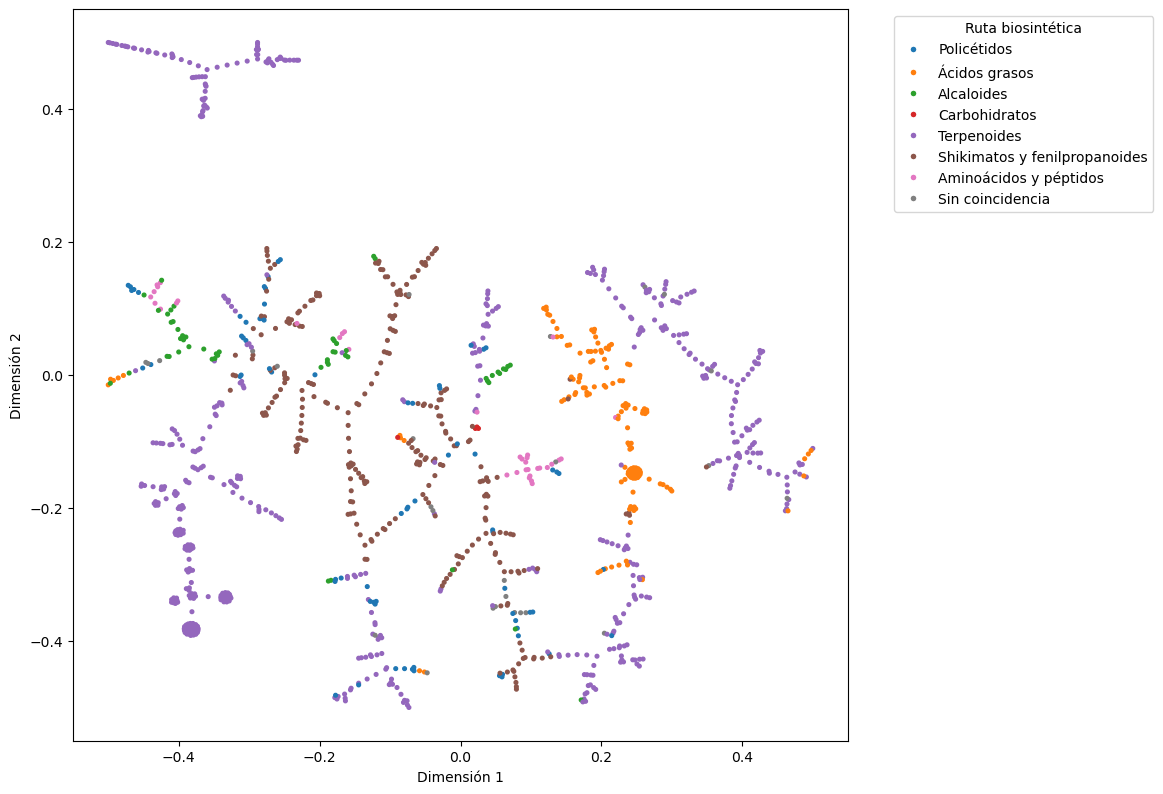

In [13]:
pathways_list = ['Polyketides', 'Fatty acids', 'Alkaloids', 'Carbohydrates', 'Terpenoids', 'Shikimates and Phenylpropanoids',
                 'Amino acids and Peptides','No match'] #Lista de rutas metabólicas

pathways_translations = ['Policétidos', 'Ácidos grasos', 'Alcaloides', 'Carbohidratos', 'Terpenoides','Shikimatos y fenilpropanoides',
    'Aminoácidos y péptidos', 'Sin coincidencia'] #Nombres traducidos a español

#Define una paleta de colores consistente con los otros gráficos
palette = sns.color_palette("tab10", len(pathways_list) - 1)  #Remueve un color de tab10 para dejar gris para 'Sin coincidencia'
fixed_color_map = {pathways_list[i]: palette[i] for i in range(len(palette))} #Asigna los colores en el orden de la lista de rutas
fixed_color_map['No match'] = 'gray'  #Asigna el gris para 'Sin coincidencia'

pathways = df_npr['NPC_PATHWAY_1'].tolist() #Crea una lista de las rutas metabólicas en el df

x, y = zip(*[(layout[0][i], layout[1][i]) for i in range(num_vertices)])  #Obtiene las coordenadas bidimensionales de cada punto

point_colors = [fixed_color_map[pathway] if pd.notna(pathway) else fixed_color_map['No match'] for pathway in pathways] #Asigna el color de cada punto

#Parámetros del gráfico
plt.figure(figsize=(10, 9.5))
scatter = plt.scatter(x, y, s=7, c=point_colors)  #Grafica como scatter plot usando los colores asignados
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")

#Crea una leyenda con los nombres traducidos de cada ruta y los colores predefinidos para cada una
handles = [plt.Line2D([0], [0], marker='o', color='w', label=pathways_translations[i], markerfacecolor=fixed_color_map[pathways_list[i]],
                      markersize=5) for i in range(len(pathways_list))]
plt.legend(title='Ruta biosintética', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('tmap1.png', dpi=300, bbox_inches='tight')  #Guarda la figura

plt.show()

In [14]:
df_sets = pd.read_csv("COMBINED_SETS_FILTERED.csv") #Carga el CSV de los conjuntos. Debe estar en la misma carpeta que el cuaderno

In [22]:
df_sets['maccs_fingerprints'] = df_sets['SMILES'].apply(smiles_to_maccs) #Aplica la función de MACCS keys a la base de datos
df_sets = df_sets.dropna(subset = ['maccs_fingerprints']) #Remueve las filas que no generaron un vector de MACCS keys

minhashes = [] #Para guardar los resultados del algoritmo de similaridad MinHash
minhash = tm.Minhash(166)  #Crea un objeto Minhash a partir de los MACCS keys (el 166 viene de la cantidad de bits del vector, 166)
for fp in df_sets['maccs_fingerprints']:
    minhashes.append(minhash.from_binary_array(list(fp)))  #Convierte los vectores en listas para posteriores pasos

lf = tm.LSHForest(166, 128)  #Genera el LSH Forest a partir de los MACCS keys, con 128 iteraciones
lf.batch_add(minhashes) #Aplica la función en lote a los minhashes
lf.index() #Asigna un índice a cada uno

k = 20  #Número de vecinos, a elección
#Listas vacias para crear el grafo de c-k-NN
knng_from = tm.VectorUint()    #Vértices de origen
knng_to = tm.VectorUint()      #Vértices destino
knng_weight = tm.VectorFloat()  #Pesos (distancias)
#Genera el grafo a partir los minhashes y guarda su información en las listas
lf.get_knn_graph(knng_from, knng_to, knng_weight, k)

#Prepara los bordes como una lista de tuplas
edges_list = [(knng_from[i], knng_to[i], knng_weight[i]) for i in range(len(knng_from))] 
num_vertices = len(df_sets)  #Un vértice por cada compuesto
layout = tm.layout_from_edge_list(num_vertices, edges_list, create_mst=True)  #Encuentra el MST

x_coords, y_coords, edge_ids_from, edge_ids_to, graph_props = layout #Obtiene las coordenadas y propiedades del grafo

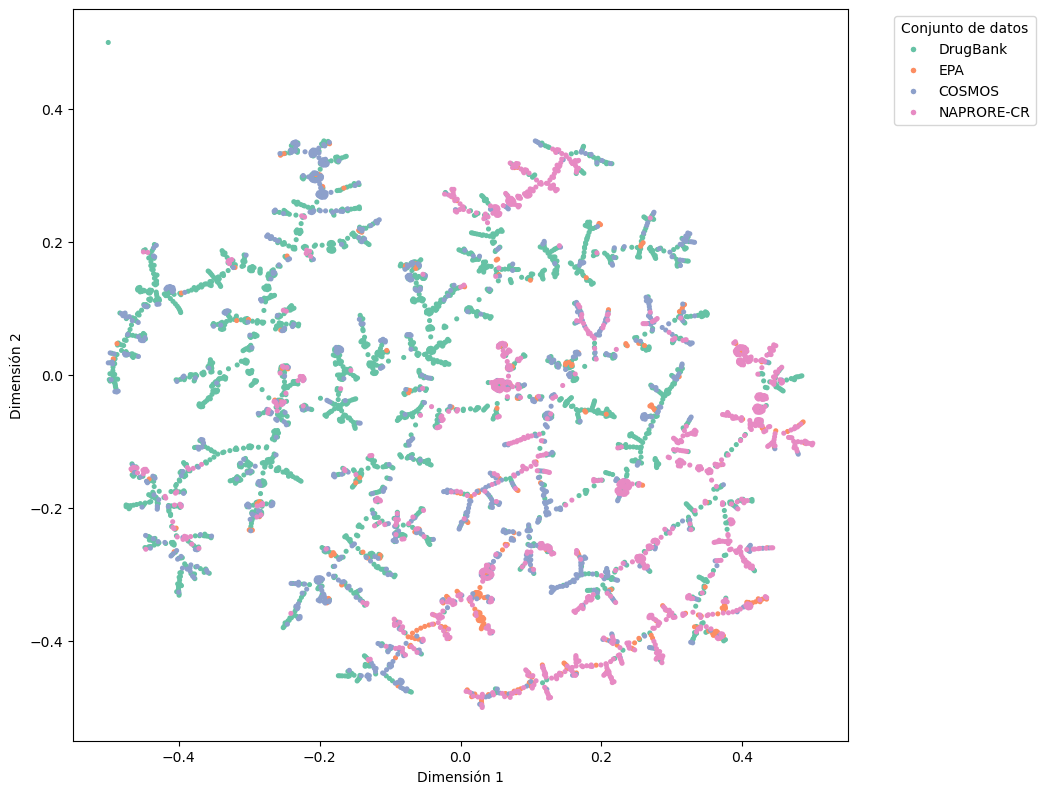

In [23]:
# Define the desired order of sets
sets_list = ['DrugBank approved', 'EPA natural pesticides', 'COSMOS cosmetic ingredients', 'NAPRORE-CR'] #Lista de conjuntos

sets = df_sets['SET'].tolist() #Crea una lista con la columna de conjuntos del df

#Define una paleta de colores consistente con los otros gráficos
palette = sns.color_palette("Set2", len(sets_list))
set_color_map = {sets_list[i]: palette[i] for i in range(len(sets_list))} #Asigna colores de Set2 en el orden de la lista de conjuntos

abbreviation_map = {'DrugBank approved': 'DrugBank', 'EPA natural pesticides': 'EPA', 'COSMOS cosmetic ingredients': 'COSMOS',
                    'NAPRORE-CR': 'NAPRORE-CR'} #Abreviaciones de cada conjunto

x, y = zip(*[(layout[0][i], layout[1][i]) for i in range(num_vertices)]) #Obtiene las coordenadas bidimensionales de cada punto

point_colors = [] #Lista para el color de cada punto
for i in range(num_vertices):
    set_name = sets[i] if i < len(sets) else 'No match' #Ubica el conjunto correspondiente a cada punto
    point_colors.append(set_color_map.get(set_name, 'gray'))  #Asigna el color gris en caso de que un punto no tenga un set asignado

#Parámetros del gráfico
plt.figure(figsize=(10, 9.5))
scatter = plt.scatter(x, y, s=7, c=point_colors)  #Grafica cada punto con el color deseado
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")

#Crea una leyenda con las abreviaturas de cada conjunto y los colores predefinidos para cada una
handles = [plt.Line2D([0], [0], marker='o', color='w', label=abbreviation_map[set_name],
                       markerfacecolor=set_color_map[set_name], markersize=5) for set_name in sets_list]

plt.legend(title='Conjunto de datos', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('tmap2.png', dpi=300, bbox_inches='tight') #Guarda la figura

plt.show()

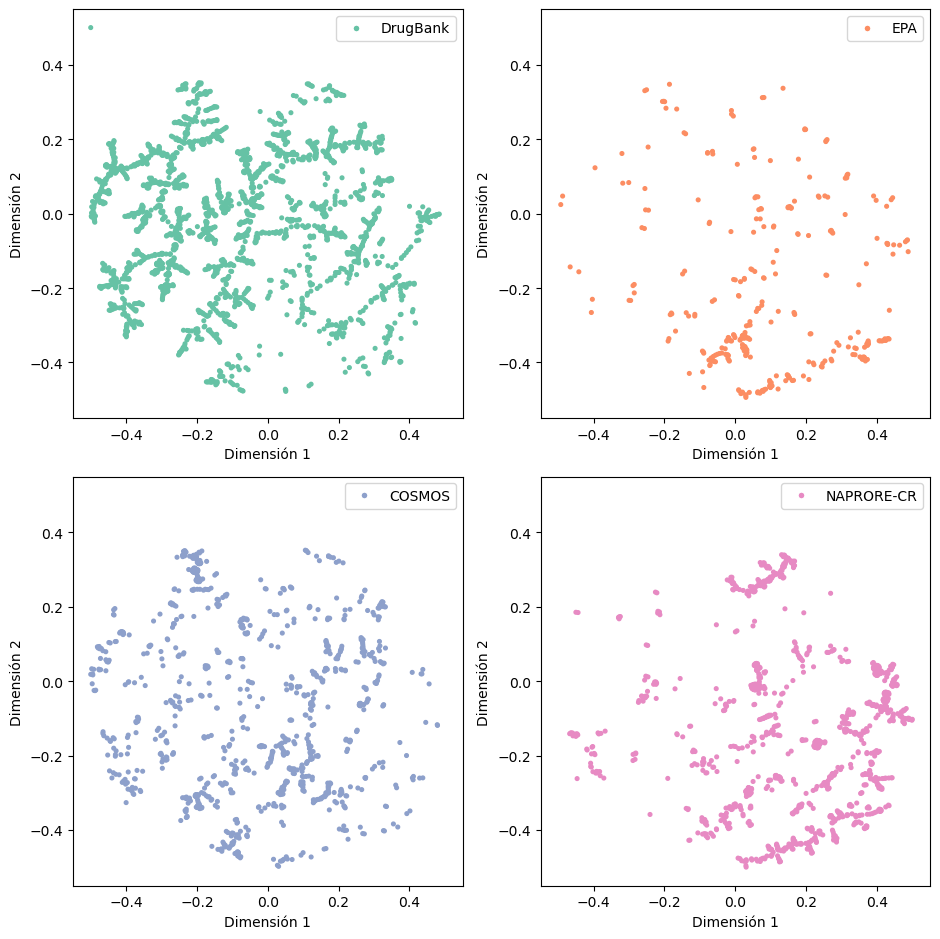

In [26]:
palette = sns.color_palette("Set2", len(sets_list))  #Define la paleta de colores
set_color_map = {set_name: palette[i] for i, set_name in enumerate(sets_list)} #Asigna colores a cada set

x, y = zip(*[(layout[0][i], layout[1][i]) for i in range(num_vertices)]) #Obtiene las coordenadas bidimensionales de cada punto

fig, axes = plt.subplots(2, 2, figsize=(9.5, 9.5)) #Crea un gráfico 2x2

axes = axes.flatten() #Aplana los ejes para facilitar su lectura

for i, set_name in enumerate(sets_list): #Ciclo para ir conjunto por conjunto graficando
    ax = axes[i]

    indices = [j for j, set_ in enumerate(sets) if set_ == set_name] #Guarda los índices de los compuestos del conjunto actual
    
    #Guarda las coordenadas de los puntos de este conjunto
    x_subset = [x[j] for j in indices]
    y_subset = [y[j] for j in indices]
    colors_subset = [set_color_map[set_name]] * len(x_subset) if indices else [] #Asigna el color correspondiente al conjunto

    ax.scatter(x_subset, y_subset, s=7, c=colors_subset) #Grafica los puntos del conjunto actual
    
    #Define los límites de los ejes de los cuatro gráficos
    ax.set_xlim(-0.55, 0.55)
    ax.set_ylim(-0.55, 0.55)
    
    ax.set_xlabel("Dimensión 1")
    ax.set_ylabel("Dimensión 2")
    
    #Añade una leyenda con las abreviaciones
    ax.legend([plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=set_color_map[set_name], markersize=5)], 
              [list(abbreviation_map.values())[i]], loc='upper right')

plt.tight_layout()

plt.savefig('tmap2_grid', dpi=300, bbox_inches='tight') #Guarda la figura

plt.show()